<a href="https://colab.research.google.com/github/heinohen/evaluation_of_machine_learning_models/blob/main/EMLM2025_exercise3_heinonen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TKO_7092 Evaluation of Machine Learning Methods 2025

---

Student name: Henrik

Student number: HIDDEN

Student email: HIDDEN

---

## Exercise 3

Complete the tasks given to you in the letter below. In your submission, explain clearly, precisely, and comprehensively why the cross-validation described in the letter failed, what is the correct way to perform cross-validation in the given scenario, and why the correct cross-validation method will give a reliable estimate of the generalisation performance. Then implement the correct cross-validation for the scenario and report its results.

Remember to follow all the general exercise guidelines that are stated in Moodle. Full points (2p) will be given for a submission that demonstrates a deep understanding of cross-validation on pair-input data and implements the requested cross-validation correctly (incl. reporting the results). Partial points (1p) will be given if there are small error(s) but the overall approach is correct. No points will be given if there are significant error(s).

The deadline of this exercise is **Wednesday 19 February 2025 at 11:59 PM**. Please contact Juho Heimonen (juaheim@utu.fi) if you have any questions about this exercise.

---


Dear Data Scientist,

I have a long-term research project regarding a specific set of proteins. I am attempting to discover small organic compounds that can bind strongly to these proteins and thus act as drugs. I have already made laboratory experiments to measure the affinities between some proteins and drug molecules.

My colleague is working on another set of proteins, and the objectives of his project are similar to mine. He has recently discovered thousands of new potential drug molecules. He asked me if I could find the pairs that have the strongest affinities among his proteins and drug molecules. Obviously I do not have the resources to measure all the possible pairs in my laboratory, so I need to prioritise. I decided to do this with the help of machine learning, but I have encountered a problem.

Here is what I have done so far: First I trained a K-nearest neighbours regressor with the parameter value K=10 using all the 400 measurements I had already made in the laboratory with my proteins and drug molecules. They comprise of 77 target proteins and 59 drug molecules. Then I performed a leave-one-out cross-validation with this same data to estimate the generalisation performance of the model. I used C-index and got a stellar score above 90%. Finally I used the model to predict the affinities of my colleague's proteins and drug molecules. The problem is: when I selected the highest predicted affinities and tried to verify them in the lab, I found that many of them are much lower in reality. My model clearly does not work despite the high cross-validation score.

Please explain why my estimation failed and how leave-one-out cross-validation should be performed to get a reliable estimate. Also, implement the correct leave-one-out cross-validation and report its results. I need to know whether it would be a waste of my resources if I were to use my model any further.

The data I used to create my model is available in the files `input.data`, `output.data` and `pairs.data` for you to use. The first file contains the features of the pairs, whereas the second contains their affinities. The third file contains the identifiers of the drug and target molecules of which the pairs are composed. The files are paired, i.e. the i<sup>*th*</sup> row in each file is about the same pair.

Looking forward to hearing from you soon.

Yours sincerely, \
Bio Scientist

---

#### Answer the questions about cross-validation on pair-input data

In [1]:
# Why did the estimation described in the letter fail?
# How should leave-one-out cross-validation be performed in the given scenario and why?
# Remember to provide comprehensive and precise arguments.


## answers

* The estimation described by Bio Scientist failed to indentify that there are dependencies between drugs and molecules and some features can only describe parts of the pair of objects or both. But the output always concers a property that is _inherent to the pair and does not exists for individual objects_.

* The leave-one-out cross-validation should be performed concerning 4 different cases. Firstly the score for the case where both drug,molecule test pair elements exist in the training set, secondly where the drug is absent and molecule present, thirdly the molecule is absent and lastly _both_ are absent from the training data (full out-of-sample example). That is how it will be done in the exercise. In these cases we'll get an idea how the knn-regressor will work in given scenarios where parts of the data are missing, generalization for the colleague. To further more expand on the idea, the value of the k can be searched from a list.


#### Import libraries

In [2]:
# Import the libraries you need.
from google.colab import drive # i run @ colab because my own computer is not very good
import numpy as np # calculations
import pandas as pd # data handling
from sklearn.model_selection import LeaveOneOut # cv
from sklearn.neighbors import KNeighborsRegressor # knn
import matplotlib.pyplot as plt # plot
from sklearn.preprocessing import StandardScaler # normalize features

#### Write utility functions

In [3]:
# Write the utility functions you need in your analysis.

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.

# this helper is from EMLM exercise 2
def cindex(y, yp):
    n = 0
    h_num = 0
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt):
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt):
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n



In [4]:
np.random.seed(42) # set random seed to get same values out

#### Load datasets

In [5]:
drive.mount('/content/drive') # connect to my drive

Mounted at /content/drive


In [6]:
# Read the data files (input.data, output.data, pairs.data).

In [7]:
# Read the file input.csv
# <ipython-input-12-9b4be0862b26>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

inputs = pd.read_csv('/content/drive/MyDrive/datasets/ELEM_3/input.data', header=None, sep='\s+') # there is no header and data is split with whitespace only
print(f'Rows: {inputs.shape[0]}, Columns: {inputs.shape[1]}')
INPUT_COLS = [str(f'feature {i+1}') for i in range(0,inputs.shape[1])]
inputs.columns = INPUT_COLS
inputs.head(5)

Rows: 400, Columns: 67


,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 58,feature 59,feature 60,feature 61,feature 62,feature 63,feature 64,feature 65,feature 66,feature 67
0,0.759222,0.709585,0.253151,0.421082,0.727780,0.404487,0.709027,0.242963,0.407292,0.379971,...,0.838616,0.165050,0.515334,0.332678,0.577533,0.678125,0.463608,0.538938,0.460883,0.345251
1,0.034584,0.304720,0.688257,0.296396,0.151878,0.830755,0.270656,0.705392,0.186120,0.085594,...,0.472762,0.730013,0.639373,0.445218,0.455680,0.090737,0.308432,0.079023,0.603089,0.197008
2,0.737867,0.236079,0.905987,0.163612,0.801455,0.789823,0.393999,0.522067,0.411352,0.781861,...,0.595468,0.582292,0.836193,0.281514,0.791790,0.081695,0.583450,0.422539,0.076437,0.299662
3,0.406913,0.607740,0.235365,0.888679,0.150347,0.598991,0.130108,0.465818,0.799953,0.906878,...,0.453880,0.311799,0.534668,0.563793,0.727767,0.172686,0.908368,0.786892,0.790459,0.666388
4,0.697707,0.432565,0.650329,0.886065,0.328660,0.576926,0.523100,0.080463,0.131349,0.913496,...,0.583892,0.444141,0.249423,0.110690,0.420770,0.250148,0.196350,0.427255,0.166715,0.919720


In [8]:
# Read the file input.csv
outputs = pd.read_csv('/content/drive/MyDrive/datasets/ELEM_3/output.data', header=None) # there is no header
print(f'Rows: {outputs.shape[0]}, Columns: {outputs.shape[1]}')
outputs.head(5)

Rows: 400, Columns: 1


,0
0,0.733933
1,0.569419
2,0.832588
3,0.389664
4,0.725953


In [9]:
# Read the file input.csv
pairs = pd.read_csv('/content/drive/MyDrive/datasets/ELEM_3/pairs.data', header=None, sep='\s+') # there is no header
print(f'Rows: {pairs.shape[0]}, Columns: {pairs.shape[1]}')
pairs.columns = ["drug", "molecule"]
pairs.head(5)

Rows: 400, Columns: 2


,drug,molecule
0,D40,T2
1,D31,T64
2,D6,T58
3,D56,T49
4,D20,T28


In [10]:
# check the features
inputs.describe()

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 58,feature 59,feature 60,feature 61,feature 62,feature 63,feature 64,feature 65,feature 66,feature 67
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.486814,0.531442,0.476554,0.460909,0.478258,0.518195,0.475177,0.504108,0.455161,0.492237,...,0.526534,0.521632,0.505073,0.540268,0.472889,0.467406,0.573579,0.500943,0.479099,0.556028
std,0.228199,0.254847,0.222032,0.263942,0.253153,0.221289,0.241901,0.256512,0.248864,0.242903,...,0.276112,0.244594,0.241548,0.237952,0.221361,0.246123,0.234814,0.242556,0.239405,0.248139
min,0.000957,0.007151,0.011780,0.016189,0.021544,0.054436,0.018604,0.002055,0.003465,0.032926,...,0.031211,0.066953,0.035105,0.024546,0.014081,0.004009,0.023899,0.020758,0.019031,0.000232
25%,0.306643,0.298480,0.300453,0.221424,0.240724,0.346390,0.262054,0.269786,0.260620,0.293705,...,0.243663,0.322595,0.302425,0.338497,0.302015,0.277000,0.396361,0.315090,0.266983,0.366710
50%,0.497088,0.542754,0.470825,0.436346,0.496462,0.520145,0.464048,0.521066,0.430459,0.506877,...,0.556083,0.496292,0.524548,0.546895,0.460614,0.442696,0.594830,0.508314,0.463408,0.577876
75%,0.680109,0.766415,0.639619,0.717094,0.692601,0.693544,0.694233,0.723093,0.632110,0.685919,...,0.760366,0.748291,0.673233,0.733776,0.644174,0.673638,0.765064,0.694956,0.684467,0.778743
max,0.943687,0.968385,0.958500,0.996686,0.975903,0.977617,0.974553,0.983629,0.988571,0.959677,...,0.994197,0.989033,0.986590,0.981325,0.980928,0.916309,0.994513,0.944396,0.987059,0.986818


In [11]:
unique_drugs = np.unique(pairs['drug'])
u_d_values = []

for u in unique_drugs:
  count_u = pairs['drug'].value_counts().get(u, 0)
  #print(f"Occurrences of {u}:", count_u)
  u_d_values.append(count_u)

u_d_df = pd.DataFrame(u_d_values, columns = ['counts'])
u_d_df.describe()

,counts
count,59.000000
mean,6.779661
std,2.356706
min,2.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,13.000000


So it is realistic to expect the count of train indices to be in range "all_indices" - [2-1,13-1]:

---



In [12]:
unique_molecules = np.unique(pairs['molecule'])
u_m_values = []

for u in unique_molecules:
  count_u = pairs['molecule'].value_counts().get(u, 0)
  #print(f"Occurrences of {u}:", count_u)
  u_m_values.append(count_u)

u_m_df = pd.DataFrame(u_m_values, columns = ['counts'])
u_m_df.describe()

,counts
count,77.000000
mean,5.194805
std,2.395385
min,1.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,12.000000


So it is realistic to expect the count of train indices to be in range "all_indices" - [1-1, 12-1]:



#### Implement and run cross-validation

In [13]:
# Implement and run the requested cross-validation. Report and interpret its results.

In [14]:

def type_B(P, O_1):
    """
    function that calculates the type "B" observations, uses list comprehension

    Parameters
      ----------
      P : ndarray
          contains the pairs.
      O_1 : str
          contains the (set of) out-of-sample value(s).

      Returns
      -------
      list
          contains the indices of the train set that does not hold O_1.
      """
    return [i for i, pair in enumerate(P) if pair[0] != O_1] # S_train = {s : s in S except p_1(s) not in O_1}

def type_C(P, O_2):
    """
    function that calculates the type "C" observations, uses list comprehension

    Parameters
      ----------
      P : ndarray
          contains the pairs.
      O_2 : str
          contains the (set of) out-of-sample value(s).

      Returns
      -------
      list
          contains the indices of the train set that does not hold O_2.
      """
    return [i for i, pair in enumerate(P) if pair[1] != O_2] # S_train = {s : s in S except p_2(s) not in O_2}

def type_D(P, O_1, O_2): # S_train = {s : s in S except p_1(s) not in O_1 except p_2(s) not in O_2}
    """
    function that calculates the type "D" observations.

    Parameters
    ----------
    P : ndarray
        contains the features.
    O_1 : str
        contains the (set of) out-of-sample value(s).
    O_2 : str
        contains the (set of) out-of-sample value(s).

    Returns
    -------
    idxs : list
        contains the indices of the train set that does not hold O_1 or O_2.
    """
    idxs = []
    for i, p in enumerate(P):
      if p[0]== O_1 or p[1] == O_2: # if either exists, move on
        continue
      else: # else append the index to the eventually new_train_indexes
        idxs.append(i)
    return idxs

def normalizer(X_train, X_test):
  """
  function that normalizes the input features to mean = 0, sd = 1.

  Parameters
  ----------
  X_train : ndarray
    contains the features of the train set.

  X_test : ndarray
    contains the features of the test set.

  Returns
  -------
  X_train_s, X_test_s : list, list
    contains the normalized versions of the train and test set.
  """
  scaler = StandardScaler() # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
  X_train_s = scaler.fit_transform(X_train) # fit and transform the X_train
  X_test_s = scaler.transform(X_test) # only transform the X_test
  return X_train_s, X_test_s


In [15]:
#### ALGO in pseudo

# for each t types do:
# implement leave-one-out with the requirements for each run
# normalize fit_transform the inputs train set and only transform the inputs test
# fit knn
# predict
# save score
# calculate c-index score from lists of true values and prediction
# save to a dict
##########

# selection of training observations

## premises

# S = set of in-sample obseravation
# S_test = set of test observations
# p_1 = mapping from observations to their first pair members
# p_2 = mapping from observations to their second pair members

## Object sets
# O_1 = set of first pair members in S_test = {o : (exists s in S_set where p_1(s) = o)}
# O_2 = set of second pair members in S_test = {o : (exists s in S_set where p_2(s) = o)}

def k_nearest_neighbours(X,Y,P,TYPE_OF_OBSERVATION,k_list) -> dict:
  """
  function that uses leave-one-out crossvalidation and KNearestNeighbor with k = 10
  to calculate c-index score for paired values in four different types of observations
  A == both values in-of-sample
  B == first value out-of-sample
  C == second value out-of-sample
  D == both values out-of-sample

  Parameters
    ----------
    X : ndarray
        contains the features.
    Y : ndarray
        contains the targets.
    P : ndarray
        contains the paired values.
    TYPE_OF_OBSERVATION : dict
        contains the four different study cases
    k_list : list
        contains k values from 2 to 2, even numbers

    Returns
    -------
    dict
        key is the type of observation, value(s) are c-index scores.
  """

### SETUP ###
  loo = LeaveOneOut()
  CINDEX_SCORES = {} # dict for scores, key is the type of observation
###
  print("working...")
  for tt in TYPE_OF_OBSERVATION: # loop through the elements "A","B","C","D"
    print(f'calculating type {tt}')
    K_SCORES = {} # store c-index for concerned k value
    for k in k_list: # loop through the k values
      knn = KNeighborsRegressor(n_neighbors=k)
      TRUE_VALS = [] # actual test output values
      PRED_VALS = [] # values predicted by the KNearestNeigbour

      # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html
      for train_index, test_index in loo.split(X): # loop through all possible splits

        # ********
        # Type A: both are in-sample-observations
        # no limitations to train set
        # no need to make modifications, keep the original arrays set above and just normalize and run fit and pred
        # ********
        if tt == "A":
          X_train, X_test = normalizer(X[train_index], X[test_index])
          Y_train, Y_test = Y[train_index], Y[test_index]
        # ********
        # Type B: first of the pair is not included
        # S_train = {s : s in S except p_1(s) not in O_1}
        # The first pair members of the test observations are not allowed to appear in the training set
        if tt == "B":
          # its a numpy.ndarray with numpy.ndarray that has two elements in the nested
          O_1 = P[test_index][0,0] # O_1 = set of first pair members in S_test = {o : (exists s in S_set where p_1(s) = o)} == set of items that hold exactly one
          new_train_indices = type_B(P,O_1) # S_train = {s : s in S except p_1(s) not in O_1}
          X_train, X_test = normalizer(X[new_train_indices], X[test_index])
          Y_train, Y_test = Y[new_train_indices], Y[test_index]
        # ********

        # ********
        # Type C: second of the pair is not included
        # S_train = {s : s in S except p_2(s) not in O_2}
        # The second pair members of the test observations are not allowed to appear in the training set
        elif tt == "C":
          # its a numpy.ndarray with numpy.ndarray that has two elements in the nested
          O_2 = P[test_index][0,1] # O_2 = set of second pair members in S_test = {o : (exists s in S_set where p_2(s) = o)}
          new_train_indices = type_C(P,O_2) # S_train = {s : s in S except p_2(s) not in O_2}
          X_train, X_test = normalizer(X[new_train_indices], X[test_index])
          Y_train, Y_test = Y[new_train_indices], Y[test_index]
        # ********

        # ********
        # Type D: neither element of the pair values is included
        # S_train = {s : s in S except p_1(s) not in O_1 except p_2(s) not in O_2}
        # None of the pair members of the test observations are allowed to appear in the training set
        elif tt == "D":
          # its a numpy.ndarray with numpy.ndarray that has two elements in the nested
          p_1 = P[test_index][0,0] # O_1 = set of first pair members in S_test = {o : (exists s in S_set where p_1(s) = o)} == set of items that hold exactly one
          p_2 = P[test_index][0,1] # # O_2 = set of second pair members in S_test = {o : (exists s in S_set where p_2(s) = o)}
          new_train_indices = type_D(P,p_1,p_2) # S_train = {s : s in S except p_1(s) not in O_1 except p_2(s) not in O_2}
          X_train, X_test = normalizer(X[new_train_indices], X[test_index])
          Y_train, Y_test = Y[new_train_indices], Y[test_index]
        # ********


        ### KNN ###
        # train the KNearestNeighborRegressor
        knn.fit(X_train,Y_train)
        # predict with the X_test
        Y_pred = knn.predict(X_test)
        ###########

        # append to lists to use for cindex calculations
        TRUE_VALS.append(Y_test[0]) # ground truth
        PRED_VALS.append(Y_pred[0]) # predictions

      c_index_value = cindex(y=TRUE_VALS, yp=PRED_VALS) # calculate the c_index_value from the y and y_pred
      #print(f"K-values: {k}")
      #print(f"C-index value: {c_index_value}")
      K_SCORES[k] = c_index_value

    CINDEX_SCORES[tt] = K_SCORES # add to the dict
  print("DONE!")
  return CINDEX_SCORES



In [16]:
%%time

# get the values so no dfs' need to be called for the loops or indexing
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy
X = inputs.to_numpy() # features
Y = outputs.to_numpy() # target
P = pairs.to_numpy() # drug, molecule pairs
k_list = np.arange(2, 22, 2).tolist()

TYPE_OF_OBSERVATION = ["A", "B", "C", "D"] # types of observation to be calculated

cind_scores = k_nearest_neighbours(X=X,
                                    Y=Y,
                                    P=P,
                                    TYPE_OF_OBSERVATION=TYPE_OF_OBSERVATION,
                                    k_list=k_list
                                    )



working...
calculating type A
calculating type B
calculating type C
calculating type D
DONE!
CPU times: user 1min 17s, sys: 8.83 s, total: 1min 26s
Wall time: 44.6 s


In [17]:
results = pd.DataFrame(columns = [str(k) for k in k_list])
for k,v in cind_scores.items():
  results.loc[len(results)] = v.values()
results.index = [str(f'Type {k}') for k in cind_scores.keys()]


In [18]:
results

,2,4,6,8,10,12,14,16,18,20
Type A,0.932368,0.919962,0.901604,0.865019,0.829361,0.793371,0.761629,0.730276,0.708985,0.700639
Type B,0.541485,0.537845,0.525683,0.514505,0.511773,0.512732,0.521604,0.525063,0.524217,0.526347
Type C,0.932500,0.919486,0.900702,0.865520,0.828709,0.793070,0.762569,0.729799,0.709699,0.702744
Type D,0.542450,0.535827,0.525865,0.514449,0.513039,0.514398,0.522049,0.525501,0.524712,0.526892


In [23]:
results['10'] # results for k = 10

,10
Type A,0.829361
Type B,0.511773
Type C,0.828709
Type D,0.513039


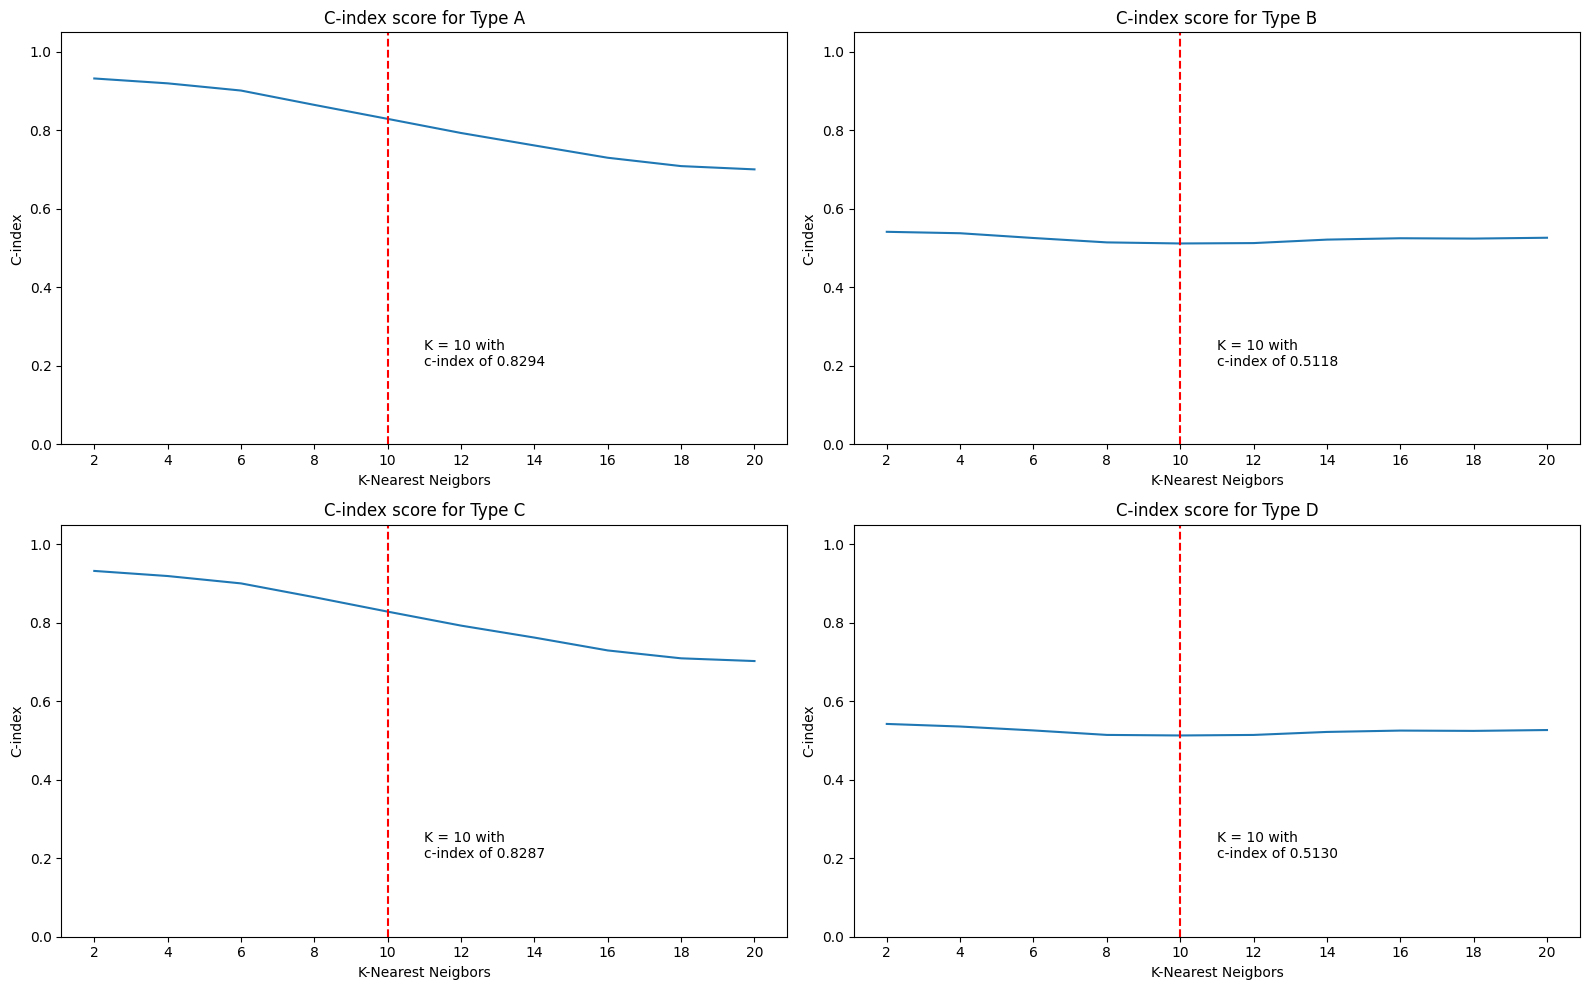

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # create 2x2 matrix
axs = axs.flatten() # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html , no need for nested loops

for i, (k, v) in enumerate(cind_scores.items()): #iterate all 4 types
    y = [j for j in v.values()] # list comprehension for all values inside the types' dict
    axs[i].plot(k_list, y, label=k) # plot x = k values, y = c-index scores
    axs[i].set_xticks(k_list) # set the x to tick at distinct k
    axs[i].set_ylim(0, 1.05) # set the y to go from 0 to a bit over 1
    axs[i].axvline(x=10, ls= "--", c= 'red') # draw vert line in k=10
    axs[i].text(x = 11, y = 0.2, s = f'K = 10 with\nc-index of {y[4]:.4f}') # info about the k=10
    axs[i].set_title(f'C-index score for Type {k}') # title
    axs[i].set_xlabel('K-Nearest Neigbors') # x-label
    axs[i].set_ylabel('C-index') # y-label

plt.tight_layout() # save space
plt.show() # show

Conclusion:

* It does look like that the predictive power of the model is high for the joint in-sample types and when only the drug is in-sample with >80% c-index score. But it lacks predictive power in the other two cases, when only the molecule is in-sample and when both of the pair is out-of-sample i.e generalization to not seen combinations.

In [21]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc &> ~/apt-log.txt
!pip3 install -q pypandoc

In [24]:
!cp drive/MyDrive/Colab\ Notebooks/EMLM2025_exercise3_heinonen.ipynb ./
!jupyter nbconvert --to PDF "EMLM2025_exercise3_heinonen.ipynb"

[NbConvertApp] Converting notebook EMLM2025_exercise3_heinonen.ipynb to PDF
[NbConvertApp] Support files will be in EMLM2025_exercise3_heinonen_files/
[NbConvertApp] Making directory ./EMLM2025_exercise3_heinonen_files
[NbConvertApp] Writing 74291 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 153256 bytes to EMLM2025_exercise3_heinonen.pdf
